<a href="https://colab.research.google.com/github/whitevo/trying_GAN/blob/master/Week_6_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

### Author:
>Tevo Saks


### Github link:
>https://github.com/whitevo/trying_GAN


### Portfolio: 
>https://github.com/whitevo

### Project Name:
> Creating Generative Adversarial Network to generate product pictures. 

### Description:
1. Creating 28x28 pixel images by building Network and training it on fashion_mnist dataset from tensorflow.keras.datasets

2. For netowork loss method using a Binary Crossentropy 

3. Training netowrk by using generator to create images and discriminator to mathematically validate them. 


### Method: 
>The goal is to use GAN network on fashion dataset and see how good  pictures it could generate.

>Creating generator with 4 LeakyRelus and tanh as actication function.

>Creating discriminator with 3 LeakyRelus and sigmoid as activation function.

>Compiling generator and discriminator with binary_crossentropy loss function.

>Generate images with numpy random noise


### Main Tools/Library:
>Python, Keras, TensorFlow, numpy, matplotlib

### Last Update:
>25.10.2019

### Used Information Resources Links:

- 1. https://github.com/iRyanBell/SAGAN-Fashion/blob/master/SAGAN_Fashion.ipynb
- 2. https://www.researchgate.net/publication/321719286_Stochastic_Reconstruction_of_an_Oolitic_Limestone_by_Generative_Adversarial_Networks
- 3. https://towardsdatascience.com/demystifying-gans-in-tensorflow-2-0-9890834ab3d9
- 4. https://github.com/zalandoresearch/fashion-mnist



# Import Dependencies

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, Flatten
from tensorflow.keras.layers import Activation, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2DTranspose
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


# Configuration

In [0]:
img_size = 112
img_channels = 1
latent_dim = 100

# Architecture
The main focus of GAN is to generate data from scratch via an adversarial process. This process consists of two models — the discriminator and the generator. The discriminator learns if a sample from a data distribution is real or fake and the generator is trying to produce fake samples and to trick the discriminator.

![alt text](https://miro.medium.com/max/4214/1*V6mQpc6MXfUH1SO9NRu-Pg.png)

In [3]:
def build_generator(img_size, img_channels, latent_dim):
  img_shape = (img_size, img_size, img_channels)
  model = Sequential()

  model.add(Dense(7 * 7 * 128, activation="relu", input_shape=(latent_dim,)))
  model.add(Reshape((7, 7, 128)))
  
  model.add(UpSampling2D())
  model.add(Conv2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  
  model.add(UpSampling2D())
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, (3, 3), padding='same', activation='tanh'))
  
  noise = Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_size, img_channels):
  img_shape = (img_size, img_size, img_channels)

  model = Sequential()
  
  init = RandomNormal(mean=0.0, stddev=0.02)

  model.add(Conv2D(128, (3, 3), kernel_initializer=init, strides=(3, 3),
                   padding='same', input_shape=img_shape))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))

  model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  img = Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def build_gan(g, d, img_size, img_channels, latent_dim):
  optimizer = Adam(lr=0.0002, beta_1=0.5)
  d.compile(optimizer, loss='binary_crossentropy', metrics=['acc'])

  z = Input(shape=(latent_dim,))
  img = g(z)

  d.trainable = False
  validity = d(img)

  gan = Model(z, validity)
  gan.compile(loss='binary_crossentropy', optimizer=optimizer)

  return gan

g = build_generator(img_size, img_channels, latent_dim)
d = build_discriminator(img_size, img_channels)

gan = build_gan(g, d, img_size, img_channels, latent_dim)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training
Generator vs Discriminator

We are going to use fashion_mnist dataset.

"*Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.*"  [(4)](https://github.com/zalandoresearch/fashion-mnist)

---


![alt text](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/embedding.gif)


Epoch: 9800/10000 - Loss: [0.8925429 0.3515625]


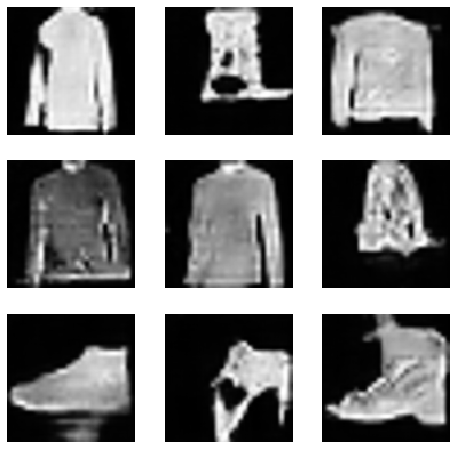

In [4]:
def train(epochs, batch_size=64, sample_interval=200, save_image=False):
  def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * y.shape[0])
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(y.shape[0])], size=n_select)
    # invert the labels in place
    y[flip_ix] = 1 - y[flip_ix]
    return y

  def sample_images(epoch):
    r, c = 3, 3
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = 0.5 * g.predict(noise) + 0.5

    fig, axs = plt.subplots(r, c, figsize=(8, 8))
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    plt.show()
    if save_image:
      fig.savefig('./preview/img-{:02d}.png'.format(epoch // sample_interval),
                  bbox_inches='tight')
    plt.close()
    
  if save_image:
    !mkdir './preview'

  # Load the dataset
  X_train_orig = fashion_mnist.load_data()[0][0]
  
  # Resize a copy of the fashion dataset
  X_train = []

  for i in range(len(X_train_orig)):
    im = Image.fromarray(X_train_orig[i]).convert('L')
    im = im.resize((img_size, img_size), Image.BICUBIC)
    X_train.append(np.array(im).astype(np.float32))

  del X_train_orig
  X_train = np.array(X_train)
  
  # Rescale -1 to 1
  X_train = X_train / 127.5 - 1.
  X_train = np.expand_dims(X_train, axis=3)

  # Adversarial ground truths
  valid = np.ones((batch_size, 1))
  valid = valid - 0.3 + (np.random.random(valid.shape) * 0.5) # Smooth
  valid = noisy_labels(valid, 0.05) # Noisy
  fake = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate a batch of new images
    gen_imgs = g.predict(noise)

    # Train the discriminator
    d_loss_real = d.train_on_batch(imgs, valid)
    d_loss_fake = d.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (to have the discriminator label samples as valid)
    g_loss = gan.train_on_batch(noise, valid)

    if epoch % sample_interval == 0:
      clear_output()
      print('Epoch: {}/{} - Loss: {}'.format(epoch, epochs, d_loss))
      sample_images(epoch)
      
train(epochs=10000, save_image=True)

# Generate 

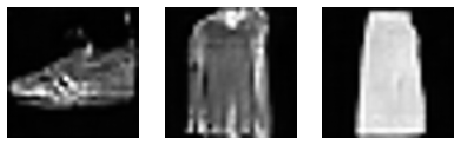

In [9]:
def gen_image(noises, cols=3):
  rows = -(-len(noises) // cols)
  fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

  for idx, noise in enumerate(noises):
    noise = np.random.normal(0, 1, (1, latent_dim))
    gen_img = np.squeeze(g.predict(noise)[0])
    gen_img = 0.5 * gen_img + 0.5
    
    x = idx // cols
    y = idx % cols
    
    if rows > 1:
      axs[x,y].imshow(gen_img, cmap='gray')
      axs[x,y].axis('off')
    else:
      axs[y].imshow(gen_img, cmap='gray')
      axs[y].axis('off')

  plt.show()
  plt.close()

noise_1 = np.random.normal(0, 1, (1, latent_dim))
noise_2 = np.random.normal(0, 1, (1, latent_dim))
noise_3 = np.random.normal(0, 1, (1, latent_dim))

gen_image([noise_1, noise_2, noise_2])